In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import distributions
from torch.utils.data import Dataset
import pandas as pd
from GMM import ISO_GMM

### The model

\begin{alignat*}{3}
    y_n | x_n & \sim \text{Bernoulli}(\sigma( w \cdot x_n )) \,\,& \forall n \in \{1, \ldots, N\}\\
    w_d & \sim \mathcal{N}(0, \alpha_d) &  \forall d \in \{1, \ldots, D\}\\
    \alpha_d & \sim \text{Gamma}(1, 0.01) &  \forall d \in \{1, \ldots, D\} .
\end{alignat*}

### Load data

In [2]:
dataset_size =  5000 # choose something smaller than 5,000,000 :)
batch_size = 128


class SUSY(Dataset):
    def __init__(self, path, nrows=None, skiprows=0):
        aux = pd.read_csv(path, nrows=nrows, skiprows=skiprows)
        self.data = torch.FloatTensor(aux.values)
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample
 
dataset = SUSY('data/SUSY.csv', nrows=dataset_size)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=0, 
                                         shuffle=True, drop_last=True)

### Define the ELBO for the Hiearchical logistic regression model

In [12]:
class LR_ELBO(nn.Module):
    def __init__(self, input_dim, var_samples=(128,)):
        # define the priors here in the constructor
        self.prior = distributions.MultivariateNormal(torch.zeros(input_dim-1), torch.eye(input_dim-1))
        self.alpha_prior = distributions.Gamma(1, 0.01)
        
        # number of samples to be used to compute ELBO gradients
        self.var_samples = var_samples
        
        
    def avg_ll(self, variational_dist, data, dataset_size):
        # this function defines the average log-likelihood
        theta = variational_dist.sample((self.var_samples,))

        weights = theta[:, 1:]
        
        y = data[:, 0]
        X = data[:, 1:]
        
        scores = torch.sigmoid(torch.mm(X, torch.t(weights)))
        Elog_lik = torch.mean( torch.mean(torch.log(scores), 1) * y - torch.mean(torch.log(1 + scores), 1))
                
        return  Elog_lik
        
    def loss(self, variational_dist, data, dataset_size):
        #Computes the ELBO
        
        # 1. Get variational samples
        theta = variational_dist.sample( (self.var_samples,))
        
        # 2. Compute negative entropy
        log_probs = variational_dist.log_prob(theta)
        neg_entropy = - log_probs.mean()        
        
        # 3. Compute the E_q[log prior] term
        alphas = torch.exp(theta[:, 0])
        alphas_lp = self.alpha_prior.log_prob(alphas).mean()
        weights = theta[:, 1:]
        weights_norm = weights / torch.sqrt(alphas).view(weights.shape[0], 1)
        log_prior = self.prior.log_prob(weights_norm)
        Elog_prior = log_prior.mean()
        
        # 4. Compute the E_q[log likelihood] term
        Elog_lik = self.avg_ll(variational_dist, data, dataset_size) * dataset_size
        
        # 5. Put all the parts together
        ELBO = Elog_lik + Elog_prior + neg_entropy
        return  ELBO

### Create variational distribution and choose optimization settings

In [13]:
variational_dist = ISO_GMM(K=4, D=18+1)
lr = 1e-1 # was 1e-3
optimizer = torch.optim.Adagrad([variational_dist.mu, variational_dist.var], lr=lr)
epochs = 200

### Optimization loop

In [14]:
elbo = LR_ELBO(input_dim=18+1, var_samples=32)

avg_ll_hist = []
avg_elbo_hist = []

for t in range(1, epochs+1):
    avg_elbo = 0.0
    avg_ll = 0
    for data in dataloader:
        # optimization step
        optimizer.zero_grad()
        loss = -elbo.loss(variational_dist, data, dataset_size)
        loss.backward()
        optimizer.step()
        
        # interesting values
        avg_elbo += loss.detach()
        avg_ll += elbo.avg_ll(variational_dist, data, dataset_size)

    avg_ll = avg_ll/len(dataloader)
    avg_elbo = -avg_elbo/len(dataloader)

    avg_ll_hist.append(avg_ll)
    avg_elbo_hist.append(avg_elbo)
    
    if t % 100 == 0:
        print('epoch %s:' % t, 'loss = %.3f' % avg_elbo)
        print('epoch %s:' % t, 'avg_ll = %.3f' % avg_ll)

epoch 100: loss = -3084.699
epoch 100: avg_ll = -0.614
epoch 200: loss = -2979.918
epoch 200: avg_ll = -0.592


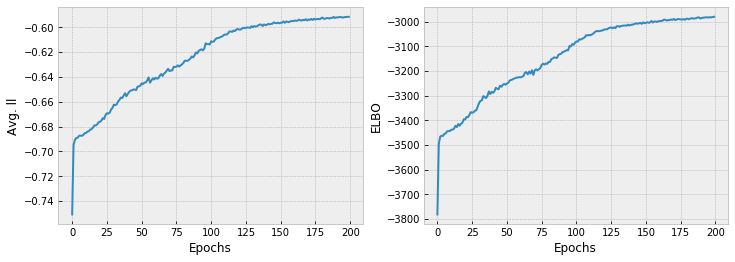

In [15]:
plt.style.use('bmh')
xaxis = np.arange(epochs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(xaxis, np.array(avg_ll_hist))
plt.xlabel('Epochs')
plt.ylabel('Avg. ll')

plt.subplot(1, 2, 2)
plt.plot(xaxis, np.array(avg_elbo_hist))
plt.xlabel('Epochs')
plt.ylabel('ELBO')
plt.show()